
# OpenAI Tool Use 教程

## 1. Tool Use 简介

什么是Tool Use（工具使用）？

Tool use也称为Function calling，可以将模型连接到外部工具和系统。OpenAI API允许我们提供一组预定义的工具，让模型在对话过程中调用这些工具。

你可以把它想象成一个**预先构建的工具箱**，里面装有各种工具函数，每个工具函数都有特定的功能和用途，**并可以实际运行**。
 
大模型在tool use中的作用是什么呢:

**决策和评估**
- 大模型会评估用户的查询和可用工具，决定是否需要使用工具来回答问题 
- 如果需要使用工具，它会决定使用哪个工具以及使用什么输入参数 

**参数处理和推理**
- 对于缺失的参数，模型能够:
  - 识别参数缺失情况,向用户请求必要的信息
  - 在合适的情况下推断合理的参数值

**工具链式使用**
- 模型能够理解需要多个工具按顺序调用的复杂任务
- 它会一步步调用工具,并使用上一个工具的输出作为下一个工具的输入 

**结果整合**
- 在收到工具执行结果后,模型会将这些信息整合到最终响应中
- 它能够处理工具执行错误,并相应地调整响应 

因此,大模型的tool use不仅仅是工具的调用,而是一个智能代理,能够理解任务需求、规划执行步骤、处理异常情况,并将结果自然地整合到回答中。**注意，API 实际上不会执行任何函数调用。开发人员是使用模型输出的函数名和入参在本地执行函数调用。**

主要应用场景：
- 实时数据获取：如查询股票价格、天气信息
- 执行操作：如预订会议、发送邮件
- 数据处理：执行计算、格式转换等
- 系统集成：与外部API和服务交互
- UI控制：根据对话更新界面元素

**教程中为方便展示已把description描述和prompt设置成中文方便观看，在真实的业务场景中想要优化效果需要改成英文的**

In [7]:
import openai
client = openai.OpenAI()

## 2. OpenAI Function Calling的工作流程

![](https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/LingYi/20241030103703.png)


1. 函数定义
*我们需要为每个函数提供详细的描述:
```python
tools = [
    {
        "type": "function",
        "function":{
            "name": "get_weather",
            "description": "获取指定城市的天气信息",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {
                        "type": "string",
                        "description": "城市名称"
                    }
                },
                "required": ["city"]
            }
        }
    }
]
```

**关键要素包括**:
- 外层要有type键和function键
- name: 函数的唯一标识名称
- description: 详细描述函数的功能和用途
- input_schema: 定义输入参数的结构
  - properties: 每个参数的类型和描述
  - required: 必需的参数列表


通过这种方式,模型就能理解(类似函数注释):
- 函数的用途和能力
- 需要什么输入参数
- 如何正确调用函数

In [18]:
tools = [
    {
        "type": "function",
        "function":{
            "name": "get_weather",
            "description": "获取指定城市的天气信息",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {
                        "type": "string",
                        "description": "城市名称"
                    }
                },
                "required": ["city"]
            }
        }
    }
]

2. API调用

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "北京今天天气如何？"}],
    tools=tools,
    # tool_choice="auto"  # 可选值："auto","required", "none", {"type": "function","function": {"name": "function_name"}}
)

In [ ]:
from rich.pretty import pprint as rpprint
rpprint(response) 

3. 处理函数调用

模型本身永远不会实际执行函数，模型只是生成可用于调用函数的参数，然后我们的本地代码可以选择如何处理这些参数，

In [46]:
if response.choices[0].message.tool_calls:
    function_call = response.choices[0].message.tool_calls[0].function
    print(function_call.name)
    print(function_call.arguments)
  

get_weather
{"city":"北京"}


以上可以截止了

什么时候适合只使用工具调用的前3步，而不用完整的工具调用呢？:

**JSON输出场景**
- 当你只需要模型返回符合特定schema的JSON输出时
- 例如记录摘要、情感分析等结构化输出场景

**实时处理场景** 
- 实时内容审核
- 数据提取和标注任务
- 代码补全等需要快速响应的场景

**独立处理场景**
- 当工具的输出不需要模型进一步解释或加工
- 当你希望自己的应用程序处理工具的输出结果

在这些场景中,我们主要使用tool use来:
1. 理解用户意图
2. 选择合适的工具
3. 构造正确的参数

这种方式可以:
- 减少API调用次数，降低延迟，让应用程序更灵活地处理结果

【实战】社交媒体或公司品牌的用户评论的情感分析

In [69]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "analyze_sentiment",
            "description": "分析文本的情感倾向并给出具体分值",
            "parameters": {
                "type": "object",
                "properties": {
                    "text": {
                        "type": "string",
                        "description": "需要分析的文本内容"
                    },
                    "language": {
                        "type": "string",
                        "description": "文本的语言",
                        "enum": ["中文", "英文"]
                    },
                    "sentiment_scores": {
                        "type": "object",
                        "description": "情感分析的具体分值",
                        "properties": {
                            "positive": {
                                "type": "number",
                                "description": "积极情感分值 (0-1)"
                            },
                            "negative": {
                                "type": "number",
                                "description": "消极情感分值 (0-1)"
                            },
                            "neutral": {
                                "type": "number",
                                "description": "中性情感分值 (0-1)"
                            }
                        }
                    }
                },
                "required": ["text", "sentiment_scores"]
            }
        }
    }
]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "分析这句话的情感：今天真是个开心的日子！"}],
    tools=tools,
    tool_choice="auto"
)

if response.choices[0].message.tool_calls:
    function_call = response.choices[0].message.tool_calls[0].function
    print(function_call.name)
    print(function_call.arguments)

analyze_sentiment
{"text":"今天真是个开心的日子！","language":"中文","sentiment_scores":{"positive":0.9,"negative":0.1,"neutral":0.0}}


后续应用举例：

analyze_sentiment
{"text":"今天真是个开心的日子！","language":"中文","sentiment_scores":{"positive":0.9,"negative":0.1,"neutral":0.0}}

=== 情感分析结果 ===
文本: 今天真是个开心的日子！
主导情感: 积极 (得分: 0.90)

详细得分:
积极: 0.90
消极: 0.10
中性: 0.00


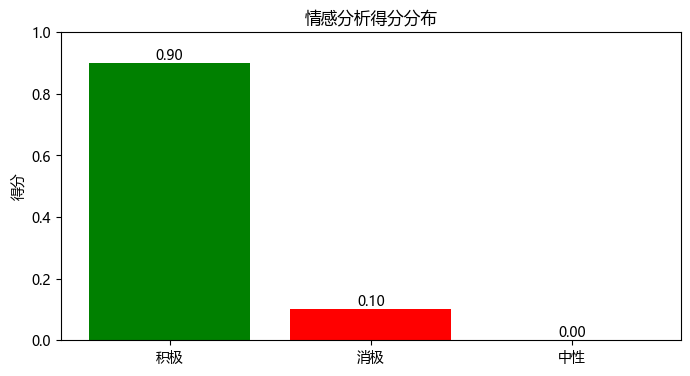

In [73]:
if response.choices[0].message.tool_calls:
    function_call = response.choices[0].message.tool_calls[0].function
    print(function_call.name)
    print(function_call.arguments)

    import json

    # 解析函数参数
    sentiment_result = json.loads(function_call.arguments)

    # 获取情感得分
    text = sentiment_result['text']
    positive_score = sentiment_result['sentiment_scores']['positive']
    negative_score = sentiment_result['sentiment_scores']['negative']
    neutral_score = sentiment_result['sentiment_scores']['neutral']

    # 确定主导情感
    scores = {
        '积极': positive_score,
        '消极': negative_score,
        '中性': neutral_score
    }
    dominant_sentiment = max(scores.items(), key=lambda x: x[1])

    # 打印分析结果
    print("\n=== 情感分析结果 ===")
    print(f"文本: {text}")
    print(f"主导情感: {dominant_sentiment[0]} (得分: {dominant_sentiment[1]:.2f})")
    print("\n详细得分:")
    print(f"积极: {positive_score:.2f}")
    print(f"消极: {negative_score:.2f}")
    print(f"中性: {neutral_score:.2f}")

    # 可视化情感得分
    import matplotlib.pyplot as plt

    sentiment_names = ['积极', '消极', '中性']
    sentiment_values = [positive_score, negative_score, neutral_score]

    plt.figure(figsize=(8, 4))
    plt.bar(sentiment_names, sentiment_values, color=['green', 'red', 'gray'])
    plt.title('情感分析得分分布')
    plt.ylabel('得分')
    plt.ylim(0, 1)

    for i, v in enumerate(sentiment_values):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center')

    plt.show()


 

适合完整5步的场景:

**需要多工具链式调用**
- 当任务需要多个工具按顺序配合完成
- 后续工具的输入依赖于前一个工具的输出，要协调多个工具的结果

**需要解释和分析结果**
- 当需要将技术结果，复杂数据转化为用户友好的解释，提供建议或见解

而3步流程适用于:

**结构化输出场景**
- 当只需要JSON格式的输出
- 数据提取和标注任务
- 不需要进一步解释的分析结果

主要区别:
- 5步流程适合需要模型智能处理和整合结果的复杂任务
- 3步流程适合直接使用工具输出的简单任务

3. 确保本地拥有函数，并使用响应中的参数调用函数

把前3步完成：

In [23]:
# **教程中为方便展示已把description描述和prompt设置成中文方便观看，在真实的业务场景中想要优化效果需要改成英文的**
tools = [
    {
        "type": "function",
        "function":{
            "name": "get_weather",
            "description": "获取指定城市的天气信息",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {
                        "type": "string",
                        "description": "城市名称"
                    }
                },
                "required": ["city"]
            }
        }
    }
]

In [24]:
messages=[{"role": "user", "content": "北京今天天气如何？"}]
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    tools=tools,
    tool_choice="auto"  # 可选值："auto","required", "none", {"type": "function","function": {"name": "function_name"}}
)

In [26]:
tool_call = response.choices[0].message.tool_calls[0].function
print(response.choices[0].message)
print(tool_call.name)
print(tool_call.arguments)

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_vTpWPLguFntWWTKz1V71dsU4', function=Function(arguments='{"city":"北京"}', name='get_weather'), type='function')])
get_weather
{"city":"北京"}


好 上面就是我们的老伙伴们了，下面我们来往下走

![](https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/LingYi/20241030103703.png)

首先建造一个本地可执行的函数，执行得到结果。再把**两次**的对话消息添加进历史消息列表里面，发送API请求

In [98]:
import json

def get_weather(city):
    """
    This function is for illustrative purposes.
    The location and unit should be used to determine weather
    instead of returning a hardcoded response.
    """

    return {
        "city": city,
        "date": "明天",
        "temperature": 22,
        "weather": "小雨",
        "humidity": 85,
        "wind": "东北风3级"
    }

In [99]:
if tool_call.name == "get_weather":
    arguments = json.loads(tool_call.arguments)  # 先将字符串转换为字典
    result = get_weather(city=arguments["city"]) # 访问字典中的 'city' 键
    print(result)

{'city': '北京', 'date': '明天', 'temperature': 22, 'weather': '小雨', 'humidity': 85, 'wind': '东北风3级'}


4. 将功能响应反馈回聊天完成 API


现在我们要向历史记录中添加消息啦，注意是大模型决定要使用工具以及我们使用工具调用的结果两条都要加

In [100]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_s7NEXyAZcVAluzmme59Yvnpj', function=Function(arguments='{"city":"北京"}', name='get_weather'), type='function')])

In [ ]:
messages.append(response.choices[0].message)

In [101]:
function_call_result_message = {
    "role": "tool",
    "content": json.dumps(result),
    "tool_call_id": response.choices[0].message.tool_calls[0].id
}
function_call_result_message


{'role': 'tool',
 'content': '{"city": "\\u5317\\u4eac", "date": "\\u660e\\u5929", "temperature": 22, "weather": "\\u5c0f\\u96e8", "humidity": 85, "wind": "\\u4e1c\\u5317\\u98ce3\\u7ea7"}',
 'tool_call_id': 'call_s7NEXyAZcVAluzmme59Yvnpj'}

使用 json.dumps 中的 ensure_ascii=False 参数，让 JSON 字符串保持原始的中文字符编码。

工具调用的消息，也就是我们本地执行的结果也要是消息格式，并且role为tool

In [103]:
function_call_result_message = {
    "role": "tool",
    "content": json.dumps(result, ensure_ascii=False),
    "tool_call_id": response.choices[0].message.tool_calls[0].id
}
function_call_result_message


{'role': 'tool',
 'content': '{"city": "北京", "date": "明天", "temperature": 22, "weather": "小雨", "humidity": 85, "wind": "东北风3级"}',
 'tool_call_id': 'call_s7NEXyAZcVAluzmme59Yvnpj'}

In [102]:
messages

[{'role': 'user', 'content': '北京今天天气如何？'}]

添加两条消息,注意顺序，gpt会校验role为tool的消息前有没有tool call的消息，同时注意tool id
![](https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/LingYi/20241031105033.png)

In [105]:
messages.append(response.choices[0].message)
messages.append(function_call_result_message)

In [106]:
messages

[{'role': 'user', 'content': '北京今天天气如何？'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_s7NEXyAZcVAluzmme59Yvnpj', function=Function(arguments='{"city":"北京"}', name='get_weather'), type='function')]),
 {'role': 'tool',
  'content': '{"city": "北京", "date": "明天", "temperature": 22, "weather": "小雨", "humidity": 85, "wind": "东北风3级"}',
  'tool_call_id': 'call_s7NEXyAZcVAluzmme59Yvnpj'}]

In [107]:
# 要添加的新消息
new_message = {"role": "system", "content": "根据天气信息，请你根据现实准确专业的给出出行，穿衣，活动建议"}

# 在第一条位置添加新消息
messages.insert(0, new_message)
messages

[{'role': 'system', 'content': '根据天气信息，请你根据现实准确专业的给出出行，穿衣，活动建议'},
 {'role': 'user', 'content': '北京今天天气如何？'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_s7NEXyAZcVAluzmme59Yvnpj', function=Function(arguments='{"city":"北京"}', name='get_weather'), type='function')]),
 {'role': 'tool',
  'content': '{"city": "北京", "date": "明天", "temperature": 22, "weather": "小雨", "humidity": 85, "wind": "东北风3级"}',
  'tool_call_id': 'call_s7NEXyAZcVAluzmme59Yvnpj'}]

In [108]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    tools=tools,
    tool_choice="auto"  # 可选值："auto","required", "none", {"type": "function","function": {"name": "function_name"}}
)
print(response.choices[0].message.content.strip())

今天北京的天气情况如下：

- **天气**：小雨
- **气温**：22°C
- **湿度**：85%
- **风速**：东北风3级

### 出行建议：
- **带雨具**：由于有小雨，请务必携带雨伞或雨衣，以防淋湿。
- **鞋子选择**：建议穿防水鞋，以保持双脚干燥。
- **出行时间**：尽量避开高峰时段，雨天可能会加大交通压力。

### 穿衣建议：
- **衣物**：穿着轻薄的长袖衣物可以抵御湿气，同时保持舒适。若能适当穿上外套或风衣，能够增加保暖效果。
- **防水外套**：若外出时间较长，建议穿一件防雨的外套。

### 活动建议：
- **室内活动**：由于天气较冷且有雨，建议选择室内活动，如去博物馆、咖啡馆等。
- **慎重户外活动**：如果要外出，注意安全，避免滑倒。

希望以上建议能帮助到您！





<span style="background-color:yellow;">> **知识点加油站**

---

知识点加油站：

1、使用 `tool_choice` 参数来控制函数调用行为

模型默认使用 `tool_choice: "auto"` 配置，即自动决定是否调用函数。你可以通过以下三种方式自定义这个行为：

1. 设置 `tool_choice: "required"` 来强制模型必须调用函数。这在需要模型在多个操作中选择下一步行动时特别有用。

2. 如果要指定调用某个具体函数，可以这样设置:
```python
tool_choice: {
    "type": "function",
    "function": {"name": "my_function"}
}
```

3. 如果想让模型只生成文本回复而不调用函数，可以不提供任何工具，或设置 `tool_choice: "none"`。

需要注意的是，当使用方式1或2强制模型调用函数时，返回的 `finish_reason` 将是 `"stop"` 而不是 `"tool_calls"`。

In [17]:
messages=[{"role": "user", "content": "北京今天天气如何？"}]
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    tools=tools,
    tool_choice={"type": "function","function": {"name": "get_weather"}}  # 可选值："auto","required", "none", {"type": "function","function": {"name": "function_name"}}
)
print(response)

ChatCompletion(id='chatcmpl-AOLd6HPvRLv4rFZCy7Lwdo5qfMPEe', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_3ds10UVubtqSn5VHrFY0WrLb', function=Function(arguments='{"city":"北京"}', name='get_weather'), type='function')]))], created=1730366380, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_0ba0d124f1', usage=CompletionUsage(completion_tokens=5, prompt_tokens=64, total_tokens=69, completion_tokens_details=CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=None, cached_tokens=0)))


2024 年 8 月，OPENAI推出了函数调用的结构化输出。当通过在函数定义中设置strict: true打开它时，结构化输出可确保模型为函数调用生成的参数与您在函数定义中提供的 JSON 架构完全匹配。



{
"type": "function",
"function": {
  "name": "get_realtime_stock_data",
    "strict": True,
  "description": "获取实时股票数据，包括当前价格、最高价和最低价。",
  "parameters": {
    "type": "object",
    "properties": {
      "ticker": {
        "type": "string",
        "description": "股票代码，例如\"AAPL\"表示苹果公司的股票。"
      }
    },
    "required": ["ticker"],
    "additionalProperties": False
  }
}

因为OpenAI的function calling对JSON Schema的要求比较严格。具体来说，需要在schema中明确指定additionalProperties: false来防止额外的属性。

In [ ]:
function_schema = {
    "name": "get_realtime_stock_data",
    "description": "Get real-time stock market data for a given stock symbol",
    "parameters": {
        "type": "object",
        "properties": {
            "symbol": {
                "type": "string",
                "description": "Stock symbol, e.g., AAPL"
            }
        },
        "required": ["symbol"],
        "additionalProperties": False  
    }
}

## 3. tool use 实战

【实战】：有维基百科帮助的写作助手

1. 定义我们的维基百科搜索功能

In [47]:
!pip install wikipedia


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached wikipedia-1.4.0.tar.gz (27 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11704 sha256=ed2675d35b93c0dda591ea36af2964f28ec7d2551cbc04dc2be0f053c02dd522
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\5e\b6\c5\93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [15]:
import openai
import json
client = openai.OpenAI()

In [28]:
import wikipedia

def get_article(search_term):
    results = wikipedia.search(search_term)
    first_result = results[0] #通常，第一个结果是与搜索词最相关的页面。
    page = wikipedia.page(first_result, auto_suggest=False) #获取与该标题对应的页面对象，然后通过 page.content 获取该页面的内容。
    return page.content

article = get_article("西游记")
print(article[:500]) 

Journey to the West (Chinese: 西遊記; pinyin: Xīyóu Jì) is a Chinese novel published in the 16th century during the Ming dynasty and attributed to Wu Cheng'en. It is regarded as one of the great Chinese novels, and has been described as arguably the most popular literary work in East Asia. It is widely known in English-speaking countries through Arthur Waley's 1942 abridged translation, Monkey.
The novel is a fictionalized and fantastic account of the pilgrimage of the Chinese Buddhist monk Xuanzan


2. 编写工具定义

In [31]:
article_search_tool = [
    {
        "type": "function",
        "function":{
            "name": "get_article",
            "description": "A tool to retrieve an up to date Wikipedia article.",
            "parameters": {
             "type": "object",
             "properties": {
                 "search_term": {
                     "type": "string",
                     "description": "The search term to find a wikipedia article by title"
                 },
             },
             "required": ["search_term"]
         }
     }
}]

3. 向GPT发送API请求，携带工具与问题 

In [32]:
messages = [{"role": "user", "content": "2024年的奥运会在哪里举行，有什么特别之处"}]

In [33]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    tools=article_search_tool,
    tool_choice= {
        "type": "function",
        "function": {"name": "get_article"}}
)  # 可选值："auto","required", "none", {"type": "function","function": {"name": "function_name"}}


4. GPT决策并返回：工具名与入参

In [34]:
if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0].function
    print("工具函数的名字:",tool_call.name)
    print("工具函数的输入:",tool_call.arguments) 

工具函数的名字: get_article
工具函数的输入: {"search_term":"2024 Summer Olympics"}


5. 本地执行工具函数,得到结果,同时记得要添加**两次**消息到历史对话中

`json.dumps()` 的作用是将 Python 对象（如字典、列表）序列化为 JSON 格式的字符串。，方便后续的存储或传输。常见的用法场景包括：

1. **存储数据**：将 Python 对象转换为 JSON 字符串并保存到文件中。
2. **数据传输**：在网络请求中，将数据序列化为 JSON 格式以便客户端与服务端的通信。

与 `json.dumps()` 相对应的反序列化方法是 `json.loads()`，它用于将 JSON 格式的字符串转回为 Python 对象。

In [37]:
if tool_call.name == "get_article":
    arguments = json.loads(tool_call.arguments)
    search_term = arguments.get("search_term")
    wiki_result = get_article(search_term)
    print(f"搜索到了 {search_term}")
    print("维基百科的原文:")
    print(wiki_result[:500])

搜索到了 2024 Summer Olympics
维基百科的原文:
The 2024 Summer Olympics (French: Jeux olympiques d'été de 2024), officially the Games of the XXXIII Olympiad (French: Jeux de la XXXIIIe olympiade de l'ère moderne) and branded as Paris 2024, were an international multi-sport event held from 26 July to 11 August 2024 in France, with several events started from 24 July. Paris was the host city, with events (mainly football) held in 16 additional cities spread across metropolitan France, including the sailing centre in the second-largest city of 


现在我们已经在本地执行了函数调用，我们需要将此函数调用的结果提供回API

In [38]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_DXEqpQOKEo1lb5v0WcYwxRnP', function=Function(arguments='{"search_term":"2024 Summer Olympics"}', name='get_article'), type='function')])

In [39]:
function_call_result_message = {
    "role": "tool",
    "content": json.dumps({
        "article": wiki_result,
    }),
    "tool_call_id": response.choices[0].message.tool_calls[0].id
}
function_call_result_message

{'role': 'tool',
 'content': '{"article": "The 2024 Summer Olympics (French: Jeux olympiques d\'\\u00e9t\\u00e9 de 2024), officially the Games of the XXXIII Olympiad (French: Jeux de la XXXIIIe olympiade de l\'\\u00e8re moderne) and branded as Paris 2024, were an international multi-sport event held from 26 July to 11 August 2024 in France, with several events started from 24 July. Paris was the host city, with events (mainly football) held in 16 additional cities spread across metropolitan France, including the sailing centre in the second-largest city of France, Marseille, on the Mediterranean Sea, as well as one subsite for surfing in Tahiti, French Polynesia.\\nParis was awarded the Games at the 131st IOC Session in Lima, Peru, on 13 September 2017. After multiple withdrawals that left only Paris and Los Angeles in contention, the International Olympic Committee (IOC) approved a process to concurrently award the 2024 and 2028 Summer Olympics to the two remaining candidate cities; b

In [36]:
messages

[{'role': 'user', 'content': '2024年的奥运会在哪里举行，有什么特别之处'}]

In [37]:
messages.append(response.choices[0].message)
messages.append(function_call_result_message)
messages

[{'role': 'user', 'content': '2024年的奥运会在哪里举行，有什么特别之处'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_ifVGreBV766HbLDJKbOfzKk1', function=Function(arguments='{"search_term":"2024 Summer Olympics"}', name='get_article'), type='function')]),
 {'role': 'tool',
  'content': '{"article": "The 2024 Summer Olympics (French: Jeux olympiques d\'\\u00e9t\\u00e9 de 2024), officially the Games of the XXXIII Olympiad (French: Jeux de la XXXIIIe olympiade de l\'\\u00e8re moderne) and branded as Paris 2024, were an international multi-sport event held from 26 July to 11 August 2024 in France, with several events started from 24 July. Paris was the host city, with events (mainly football) held in 16 additional cities spread across metropolitan France, including the sailing centre in the second-largest city of France, Marseille, on the Mediterranean Sea, as well as one subsite for surfing in Tahiti, French Pol

6. 向GPT提供本地执行的工具结果, GPT处理结果与上下文，加工出最终回答

In [38]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    tools=article_search_tool,
    tool_choice= "auto"
)  # 可选值："auto","required", "none", {"type": "function","function": {"name": "function_name"}}
print(response.choices[0].message.content.strip())

2024年夏季奥运会（Paris 2024）将在法国巴黎举行，比赛时间从2024年7月26日到8月11日，部分赛事将从7月24日开始。以下是这届奥运会的一些特殊之处：

1. **历史重返**: 巴黎是唯一一座三次举办夏季奥运会的城市（之前分别在1900年和1924年举行）。2024年正好是1924年奥运会的百年纪念。

2. **开幕式创新**: 本届奥运会的开幕式将首次在体育场外举行，运动员将在塞纳河上乘船进行游行，成为现代奥运历史上的一大亮点。

3. **项目变化**: 此次奥运会将首次将“breaking”（霹雳舞）作为正式比赛项目，同时还将保留2020年首次引入的滑板、攀岩和冲浪等项目。

4. **性别平等**: 2024年巴黎奥运会是历史上首次实现场上人数性别平衡，男女运动员人数相等。

5. **可持续性**: 在食物供应上，奥运会将提供更多的植物性食品，以减少环境影响。

6. **安全措施**: 鉴于安全顾虑，法国将部署大量警力，并与多个国家合作加强安全，确保活动顺利进行。

这届奥运会还将是国际奥委会主席托马斯·巴赫执掌下举行的最后一届夏季奥运会，预计将吸引大量观众和参与者。


【实战】 打造完整的tool use脚本(初级)

In [109]:
def run_conversation(messages, tools, available_tools):
    """
    运行与 GPT 模型的对话，并处理函数调用。
    
    参数:
        messages (list): 对话消息列表。
        tools (list): 可用函数的列表。
        available_tools (dict): 可用函数的映射。
    
    返回:
        dict: GPT 模型的响应。
    """
    
    # 步骤 1：将对话和可用函数发送给 GPT
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        tools=tools,
        tool_choice="auto", 
    )
    response_message = response.choices[0].message

    # 步骤 2：检查 GPT 模型是否希望调用某个函数
    if response_message.tool_calls:
        print("推荐的函数调用:")
        print(response_message.tool_calls[0])
        print()
        
        # 步骤 3：调用相应的函数

        # 获取函数名称
        tool_name = response_message.tool_calls[0].function.name
        
        # 验证函数是否存在
        if tool_name not in available_tools:
            return f"函数 {tool_name} 不存在"
        function_to_call = available_tools[tool_name] 
        
        # 获取函数参数
        try:
            function_args = json.loads(response_message.tool_calls[0].function.arguments)
            # 移除值为空的参数
            function_args = {k: v for k, v in function_args.items() if v != ""}
        except json.JSONDecodeError:
            return "函数参数的 JSON 格式不正确"
        
        # 调用函数并获取响应
        if tool_name == "get_article":
            tool_response= function_to_call(function_args["search_term"])
        
        print("函数调用的输出:")
        print(tool_response)
        print()
        
        # 步骤 4：将函数调用的信息和响应添加到消息中
        
        # 将助手的函数调用添加到消息列表
        messages.append(
            response_message
        )

        # 将函数的响应添加到消息列表
        messages.append(
            {
                "role": "tool",
                "content": tool_response,
                "tool_call_id": response.choices[0].message.tool_calls[0].id
            }
        )

        # 显示第二次请求的消息
        print("第二次请求中的消息:")
        for message in messages:
            print(message)
        print()

        # 获取 GPT 的第二次响应
        second_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            tools=tools,
            tool_choice="auto", 
        )  
        return second_response
    else:
        # 如果没有函数调用，直接返回 GPT 的响应
        return response


# 定义可用的工具（函数）映射
available_tools = {
    "get_article": get_article,
}

# 定义对话消息
messages = [
    {"role": "user", "content":"2024年有什么重大的国际事件，讲解总结"}
]


# 运行对话
assistant_response = run_conversation(messages, article_search_tool, available_tools)

# 打印助手的响应
print(assistant_response.choices[0].message.content)


2024年将有几个重大的国际事件，这些事件可能会对全球政治、经济以及社会文化产生深远的影响。以下是一些关键事件的总结：

1. **美国总统选举**：
   - 2024年11月，美国将举行总统选举。这次选举将决定美国的未来领导者，包括相关政策方向，对内外事务的影响等。预计选举过程将充满竞争，可能涉及多位候选人，并且将对国际关系产生重要影响。

2. **巴黎气候会议（COP29）**：
   - 2024年，联合国将再次召开气候变化会议，各国将在巴黎讨论如何应对气候变化的挑战，并推进全球减排目标。这次会议将是评估各国在气候协议下的承诺执行情况的重要时刻，可能出现新的合作机制和资金支持方案。

3. **奥林匹克运动会**：
   - 2024年巴黎将举办夏季奥林匹克运动会。这一盛事不仅是体育界的重大事件，也将促进旅游、经济发展和国际文化交流。疫情后，重启大型国际体育赛事的意义尤其重要。

4. **科技与安全会议**：
   - 随着科技发展尤其是人工智能和网络安全的重要性日益突出，2024年可能会举行多次国际会议，讨论这些技术的监管、伦理和国际安全等问题。

5. **地缘政治动荡**：
   - 在一些地区，地缘政治关系的紧张可能会加剧，如中美关系、俄罗斯与西方国家的关系等。2024年可能会出现一些重要的外交努力或冲突，影响全球稳定。

这些事件不仅是国际事务的重要节点，也反映了全球政治经济的发展动态。各国的反应和参与将决定未来几年的国际形势走向。


发现并没有调用工具，tool_choice加上强制调用

In [41]:
def run_conversation(messages, tools, available_tools):
    """
    运行与 GPT 模型的对话，并处理函数调用。
    
    参数:
        messages (list): 对话消息列表。
        tools (list): 可用函数的列表。
        available_tools (dict): 可用函数的映射。
    
    返回:
        dict: GPT 模型的响应。
    """
    
    # 步骤 1：将对话和可用函数发送给 GPT
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        tools=tools,
        tool_choice={"type": "function", "function": {"name": "get_article"}}, 
    )
    response_message = response.choices[0].message

    # 步骤 2：检查 GPT 模型是否希望调用某个函数
    if response_message.tool_calls:
        print("推荐的函数调用:")
        print(response_message.tool_calls[0])
        print()
        
        # 步骤 3：调用相应的函数

        # 获取函数名称
        tool_name = response_message.tool_calls[0].function.name
        
        # 验证函数是否存在
        if tool_name not in available_tools:
            return f"函数 {tool_name} 不存在"
        function_to_call = available_tools[tool_name] 
        
        # 获取函数参数
        try:
            function_args = json.loads(response_message.tool_calls[0].function.arguments)
            # 移除值为空的参数
            function_args = {k: v for k, v in function_args.items() if v != ""}
        except json.JSONDecodeError:
            return "函数参数的 JSON 格式不正确"
        
        # 调用函数并获取响应
        if tool_name == "get_article":
            tool_response= function_to_call(function_args["search_term"])
        
        print("函数调用的输出:")
        print(tool_response)
        print()
        
        # 步骤 4：将函数调用的信息和响应添加到消息中
        
        # 将助手的函数调用添加到消息列表
        messages.append(
            response_message
        )

        # 将函数的响应添加到消息列表
        messages.append(
            {
                "role": "tool",
                "content": tool_response,
                "tool_call_id": response.choices[0].message.tool_calls[0].id
            }
        )

        # 显示第二次请求的消息
        print("第二次请求中的消息:")
        for message in messages:
            print(message)
        print()

        # 获取 GPT 的第二次响应
        second_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            tools=tools,
            tool_choice="none", 
        )  
        return second_response
    else:
        # 如果没有函数调用，直接返回 GPT 的响应
        return response


# 定义可用的工具（函数）映射
available_tools = {
    "get_article": get_article,
}

# 定义对话消息
messages = [
    {"role": "user", "content":"2024年的诺贝尔有什么信息，为什么，讲解一下"}
]


# 运行对话
assistant_response = run_conversation(messages, article_search_tool, available_tools)

# 打印助手的响应
print(assistant_response.choices[0].message.content)


推荐的函数调用:
ChatCompletionMessageToolCall(id='call_PPI81wAHyvSjjJx4DI91qUNe', function=Function(arguments='{"search_term":"2024 Nobel Prize"}', name='get_article'), type='function')

函数调用的输出:
The 2024 Nobel Prize in Literature was awarded to the South Korean author Han Kang (born 1970) "for her intense poetic prose that confronts historical traumas and exposes the fragility of human life". It was announced by the Swedish Academy in Stockholm, Sweden, on 10 October 2024 and will be awarded on 10 December 2024. 
She is the first South Korean and the first Asian female Nobel laureate in literature, and the first Asian author to win the prize since Mo Yan in 2012.


== Laureate ==

Han Kang grew up with a literary background in Seoul, her father, Han Seung-won, being a reputed novelist. Alongside her passion for writing, she spends time exploring arts and music, which is reflected throughout her literary production. She started her career in 1993 with the publication of her poems in the liter

## tool use 的并行调用

OPENAI的函数调用支持许多高级功能，例如强制函数调用、并行函数调用等。
默认是开启的，可通过提供 parallel_tool_calls： false 来禁用并行函数调用。

可想而知，我们的工具箱里面常常有多个工具，同时选择使用多个工具常常是我们的需求。我们通过一个股票的实战来看看效果。

【实战】并行的函数调用与实时股票价格、股票历史走势绘图、股票历史走势分析

In [42]:
! pip install yfinance matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import matplotlib.pyplot as plt
import matplotlib
import platform

def set_chinese_font():
    if platform.system() == 'Windows':
        plt.rcParams['font.family'] = ['Microsoft YaHei']  # 微软雅黑
    elif platform.system() == 'Darwin':  # macOS
        plt.rcParams['font.family'] = ['Arial Unicode MS']  # 苹果系统默认支持的中文字体
    else:
        plt.rcParams['font.family'] = ['SimHei']  # 黑体，可能需要自行安装

    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

函数2：获取历史股票数据并绘制价格图

In [44]:
def historical_stock_data(ticker, period='1mo', interval='1d'):
    set_chinese_font()  # 设置中文字体
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data['Close'], label='收盘价')
    plt.title(f"{ticker} 股票价格走势")
    plt.xlabel("日期")
    plt.ylabel("价格")
    plt.legend()
    plt.grid(True)
    plt.show()
    # 将数据转换为更易读的格式
    data.reset_index(inplace=True)  # 重置索引
    formatted_data = data.to_dict(orient='records')  # 转换为字典格式
    return formatted_data


函数1：获取实时股票数据

In [45]:
import yfinance as yf

def get_realtime_stock_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(period="1d", interval="1m")
    latest_data = data.tail(1)
    current_price = latest_data['Close'].iloc[0]
    high_price = data['High'].max()
    low_price = data['Low'].min()
    return current_price, high_price, low_price


当前价格: 230.13999938964844
最高价格: 233.2299041748047
最低价格: 229.55999755859375


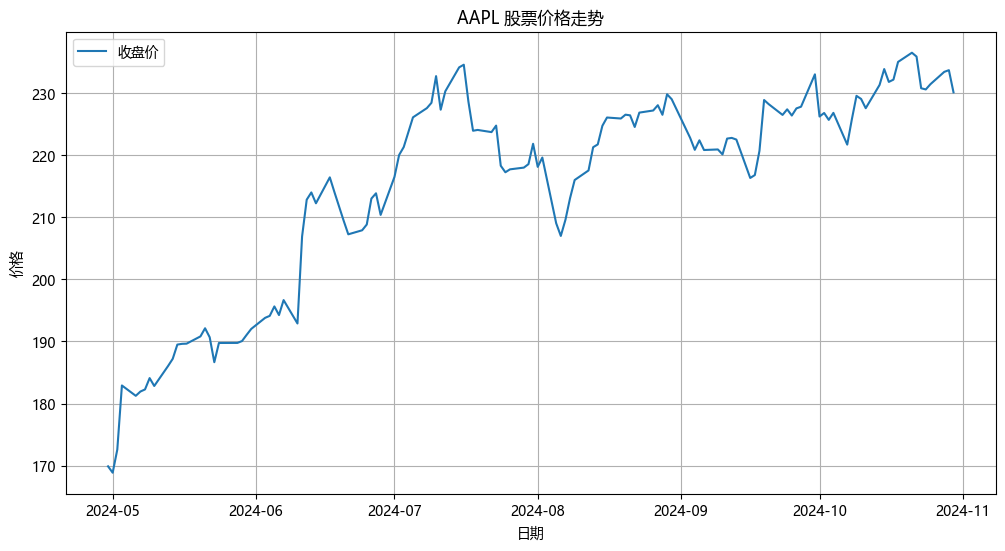

[{'Date': Timestamp('2024-04-30 00:00:00-0400', tz='America/New_York'),
  'Open': 172.8950909599863,
  'High': 174.55092942489358,
  'Low': 169.57344460104667,
  'Close': 169.90261840820312,
  'Volume': 65934800,
  'Dividends': 0.0,
  'Stock Splits': 0.0},
 {'Date': Timestamp('2024-05-01 00:00:00-0400', tz='America/New_York'),
  'Open': 169.15450985940603,
  'High': 172.27666126931797,
  'Low': 168.68568791540957,
  'Close': 168.87521362304688,
  'Volume': 50383100,
  'Dividends': 0.0,
  'Stock Splits': 0.0},
 {'Date': Timestamp('2024-05-02 00:00:00-0400', tz='America/New_York'),
  'Open': 172.07715616360477,
  'High': 172.98487656972907,
  'Low': 170.4612257152764,
  'Close': 172.59585571289062,
  'Volume': 94214900,
  'Dividends': 0.0,
  'Stock Splits': 0.0},
 {'Date': Timestamp('2024-05-03 00:00:00-0400', tz='America/New_York'),
  'Open': 186.18166020430448,
  'High': 186.5307880883928,
  'Low': 182.20168147231004,
  'Close': 182.9198760986328,
  'Volume': 163224100,
  'Dividends': 

In [48]:
# 获取实时股票数据
current_price, high_price, low_price = get_realtime_stock_data('AAPL')
print(f"当前价格: {current_price}")
print(f"最高价格: {high_price}")
print(f"最低价格: {low_price}")

# 绘制历史股票价格图
historical_stock_data('AAPL', period='6mo', interval='1d')

In [49]:
import inspect

def function_to_schema(func) -> dict:
    type_map = {
        str: "string",
        int: "integer",
        float: "number",
        bool: "boolean",
        list: "array",
        dict: "object",
        type(None): "null",
    }

    try:
        signature = inspect.signature(func)
    except ValueError as e:
        raise ValueError(
            f"Failed to get signature for function {func.__name__}: {str(e)}"
        )

    parameters = {}
    for param in signature.parameters.values():
        try:
            param_type = type_map.get(param.annotation, "string")
        except KeyError as e:
            raise KeyError(
                f"Unknown type annotation {param.annotation} for parameter {param.name}: {str(e)}"
            )
        parameters[param.name] = {"type": param_type}

    required = [
        param.name
        for param in signature.parameters.values()
        if param.default == inspect._empty
    ]

    return {
        "type": "function",
        "function": {
            "name": func.__name__,
            "description": (func.__doc__ or "").strip(),
            "parameters": {
                "type": "object",
                "properties": parameters,
                "required": required,
            },
        },
    }

In [52]:
tools=[]
tools.append(function_to_schema(get_realtime_stock_data))
tools.append(function_to_schema(historical_stock_data))
tools

[{'type': 'function',
  'function': {'name': 'get_realtime_stock_data',
   'description': '',
   'parameters': {'type': 'object',
    'properties': {'ticker': {'type': 'string'}},
    'required': ['ticker']}}},
 {'type': 'function',
  'function': {'name': 'plot_historical_stock_data',
   'description': '',
   'parameters': {'type': 'object',
    'properties': {'ticker': {'type': 'string'},
     'period': {'type': 'string'},
     'interval': {'type': 'string'}},
    'required': ['ticker']}}}]

In [53]:
# **教程中为方便展示已把description描述和prompt设置成中文方便观看，在真实的业务场景中想要优化效果需要改成英文的**
tools=[
  {
    "type": "function",
    "function": {
      "name": "get_realtime_stock_data",
        "strict": True,
      "description": "获取实时股票数据，包括当前价格、最高价和最低价。",
      "parameters": {
        "type": "object",
        "properties": {
          "ticker": {
            "type": "string",
            "description": "股票代码，例如\"AAPL\"表示苹果公司的股票。"
          }
        },
        "required": ["ticker"],
        "additionalProperties": False
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "historical_stock_data",
      "strict": True,
      "description": "获取历史股票数据并分析。",
      "parameters": {
        "type": "object",
        "properties": {
          "ticker": {
            "type": "string",
            "description": "股票代码，例如\"AAPL\"表示苹果公司的股票。"
          },
          "period": {
            "type": "string",
            "description": "数据周期，must be one of, ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']，找到最接近的参数值"
          },
          "interval": {
            "type": "string",
            "description": "数据间隔，例如\"1d\"表示1天，默认为\"1d\"。可选值包括\"1m\"、\"2m\"、\"5m\"、\"15m\"、\"30m\"、\"60m\"、\"90m\"、\"1h\"、\"1d\"、\"5d\"、\"1wk\"、\"1mo\"、\"3mo\"。找到和数据周期相搭配的合理的值"
          }
        },
        "required": ["ticker", "period", "interval"],
        "additionalProperties": False
      }
    }
  }
]


用之前写的脚本不能解析并行的工具调用

In [51]:
def run_conversation(messages, tools, available_tools):
    """
    运行与 GPT 模型的对话，并处理函数调用。
    
    参数:
        messages (list): 对话消息列表。
        tools (list): 可用函数的列表。
        available_tools (dict): 可用函数的映射。
    
    返回:
        dict: GPT 模型的响应。
    """
    
    # 步骤 1：将对话和可用函数发送给 GPT
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        tools=tools,
        tool_choice="auto", 
    )
    response_message = response.choices[0].message

    # 步骤 2：检查 GPT 模型是否希望调用某个函数
    if response_message.tool_calls:
        print("推荐的函数调用:")
        print(response_message.tool_calls[0])
        print()
        
        # 步骤 3：调用相应的函数

        # 获取函数名称
        tool_name = response_message.tool_calls[0].function.name
        
        # 验证函数是否存在
        if tool_name not in available_tools:
            return f"函数 {tool_name} 不存在"
        function_to_call = available_tools[tool_name] 
        
        # 获取函数参数
        try:
            function_args = json.loads(response_message.tool_calls[0].function.arguments)
            # 移除值为空的参数
            function_args = {k: v for k, v in function_args.items() if v != ""}
        except json.JSONDecodeError:
            return "函数参数的 JSON 格式不正确"
        
        # 调用函数并获取响应
        try:
            # 针对不同函数的调用方式
            if tool_name == "get_realtime_stock_data":
                tool_response1, tool_response2, tool_response3 = function_to_call(function_args["ticker"])
                tool_response = f"当前价格: {tool_response1}, 最高价格: {tool_response2}, 最低价格: {tool_response3}"
            elif tool_name == "historical_stock_data":
                # 调用绘图函数
                function_to_call(function_args["ticker"], function_args.get("period", "1mo"), function_args.get("interval", "1d"))
                tool_response = "已生成历史股票价格走势图。"
            else:
                tool_response = "未知的函数调用。"
        except Exception as e:
            tool_response = f"调用函数时出错: {e}"
        
        print("函数调用的输出:")
        print(tool_response)
        print()
        
        # 步骤 4：将函数调用的信息和响应添加到消息中
        
        # 将助手的函数调用添加到消息列表
        messages.append(
            response_message
        )

        # 将函数的响应添加到消息列表
        messages.append(
            {
                "role": "tool",
                "content": tool_response,
                "tool_call_id": response.choices[0].message.tool_calls[0].id
            }
        )

        # 显示第二次请求的消息
        print("第二次请求中的消息:")
        for message in messages:
            print(message)
        print()

        # 获取 GPT 的第二次响应
        second_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            tools=tools,
            tool_choice="auto", 
        )  
        return second_response
    else:
        # 如果没有函数调用，直接返回 GPT 的响应
        return response




# 定义对话消息
messages = [
    {"role": "user", "content": "我想知道苹果的现在股票价格，以及它这周的历史走势"}
]

# 定义可用的工具（函数）映射
available_tools = {
    "get_realtime_stock_data": get_realtime_stock_data,
    "historical_stock_data": historical_stock_data
}

# 运行对话
assistant_response = run_conversation(messages, tools, available_tools)

# 打印助手的响应
print(assistant_response.choices[0].message.content)


KeyboardInterrupt: 

In [52]:
import  json

推荐的函数调用:
ChatCompletionMessageToolCall(id='call_wa5UgHD09OqJL4UaN2vF0Xhu', function=Function(arguments='{"ticker": "AAPL"}', name='get_realtime_stock_data'), type='function')
ChatCompletionMessageToolCall(id='call_nAm8oxh5h6JKzpkOOmUm7QAJ', function=Function(arguments='{"ticker": "AAPL", "period": "5d", "interval": "1d"}', name='historical_stock_data'), type='function')


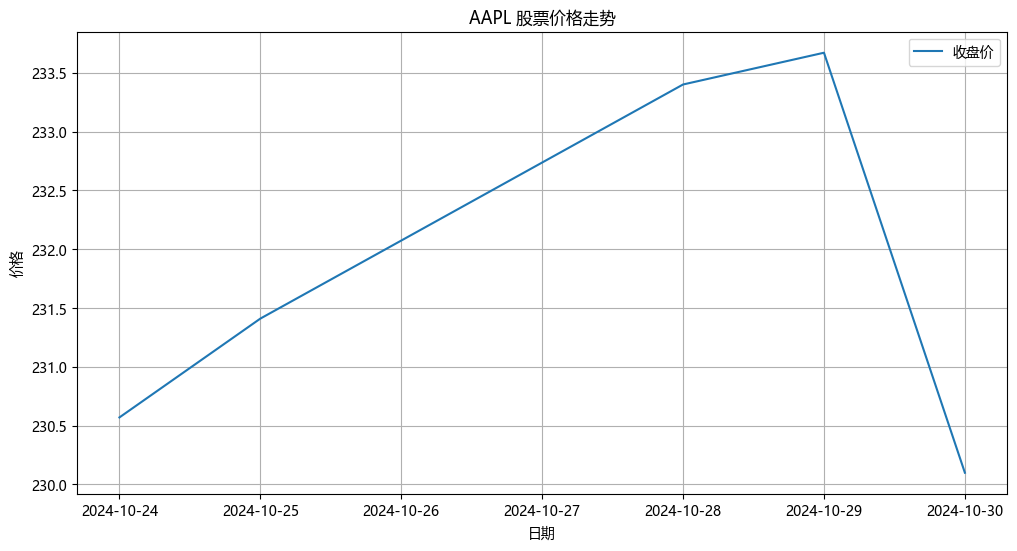

函数调用的输出:
当前价格: 230.13999938964844, 最高价格: 233.2299041748047, 最低价格: 229.55999755859375
请读取分析它的数据，作为一个专业的金融人员给出具体的见解和指导，要更深入的分析：[{'Date': Timestamp('2024-10-24 00:00:00-0400', tz='America/New_York'), 'Open': 229.97999572753906, 'High': 230.82000732421875, 'Low': 228.41000366210938, 'Close': 230.57000732421875, 'Volume': 31109500, 'Dividends': 0.0, 'Stock Splits': 0.0}, {'Date': Timestamp('2024-10-25 00:00:00-0400', tz='America/New_York'), 'Open': 229.74000549316406, 'High': 233.22000122070312, 'Low': 229.57000732421875, 'Close': 231.41000366210938, 'Volume': 38802300, 'Dividends': 0.0, 'Stock Splits': 0.0}, {'Date': Timestamp('2024-10-28 00:00:00-0400', tz='America/New_York'), 'Open': 233.32000732421875, 'High': 234.72999572753906, 'Low': 232.5500030517578, 'Close': 233.39999389648438, 'Volume': 36087100, 'Dividends': 0.0, 'Stock Splits': 0.0}, {'Date': Timestamp('2024-10-29 00:00:00-0400', tz='America/New_York'), 'Open': 233.10000610351562, 'High': 234.3300018310547, 'Low': 232.320007324

In [11]:
def run_conversation(messages, tools, available_tools):
    """
    运行与 GPT 模型的对话，并处理函数调用。
    
    参数:
        messages (list): 对话消息列表。
        tools (list): 可用函数的列表。
        available_tools (dict): 可用函数的映射。
    
    返回:
        dict: GPT 模型的响应。
    """
    
    # 步骤 1：将对话和可用函数发送给 GPT
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        tools=tools,
        tool_choice="auto", 
    )
    response_message = response.choices[0].message

    # 步骤 2：检查 GPT 模型是否希望调用某个函数
    if response_message.tool_calls:
        print("推荐的函数调用:")
        
        tool_responses = []  # 存储所有函数调用的响应
        
        for tool_call in response_message.tool_calls:
            print(tool_call)
            tool_name = tool_call.function.name
            
            # 验证函数是否存在
            if tool_name not in available_tools:
                tool_responses.append(f"函数 {tool_name} 不存在")
                continue
            
            function_to_call = available_tools[tool_name] 
            
            # 获取函数参数
            try:
                function_args = json.loads(tool_call.function.arguments)
                # 移除值为空的参数
                function_args = {k: v for k, v in function_args.items() if v != ""}
            except json.JSONDecodeError:
                tool_responses.append("函数参数的 JSON 格式不正确")
                continue
            
            # 调用函数并获取响应
            try:
                if tool_name == "get_realtime_stock_data":
                    tool_response1, tool_response2, tool_response3 = function_to_call(function_args["ticker"])
                    tool_response = f"当前价格: {tool_response1}, 最高价格: {tool_response2}, 最低价格: {tool_response3}"
                elif tool_name == "historical_stock_data":
                    data=function_to_call(function_args["ticker"], function_args.get("period", "1mo"), function_args.get("interval", "1d"))
                    tool_response = f"请读取分析它的数据，作为一个专业的金融人员给出具体的见解和指导，要更深入的分析：{data}"
                else:
                    tool_response = "未知的函数调用。"
            except Exception as e:
                tool_response = f"调用函数时出错: {e}"
            
            tool_responses.append(tool_response)

        print("函数调用的输出:")
        for response in tool_responses:
            print(response)
        print()
        
        # 步骤 4：将函数调用的信息和响应添加到消息中
        
        # 将助手的函数调用添加到消息列表
        messages.append(response_message)

        # 将函数的响应添加到消息列表
        for idx, response in enumerate(tool_responses):
            messages.append(
                {
                    "role": "tool",
                    "content": response,
                    "tool_call_id": response_message.tool_calls[idx].id
                }
            )

        # 显示第二次请求的消息
        print("第二次请求中的消息:")
        for message in messages:
            print(message)
        print()

        # 获取 GPT 的第二次响应
        second_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            tools=tools,
            tool_choice="auto", 
        )  
        return second_response
    else:
        # 如果没有函数调用，直接返回 GPT 的响应
        return response


# 定义对话消息
messages = [
    {"role": "user", "content": "我想知道苹果的现在股票价格，以及它这周的历史走势与分析"}
]

# 定义可用的工具（函数）映射
available_tools = {
    "get_realtime_stock_data": get_realtime_stock_data,
    "historical_stock_data": historical_stock_data
}

# 运行对话
assistant_response = run_conversation(messages, tools, available_tools)

# 打印助手的响应
print(assistant_response.choices[0].message.content)


推荐的函数调用:
ChatCompletionMessageToolCall(id='call_JiKAZpbxEiGufI5LWNkVTCdu', function=Function(arguments='{"ticker": "NVDA"}', name='get_realtime_stock_data'), type='function')
ChatCompletionMessageToolCall(id='call_4jk4bZQnFYTNLFhDQoj7flTm', function=Function(arguments='{"ticker": "NVDA", "period": "6mo", "interval": "1d"}', name='historical_stock_data'), type='function')


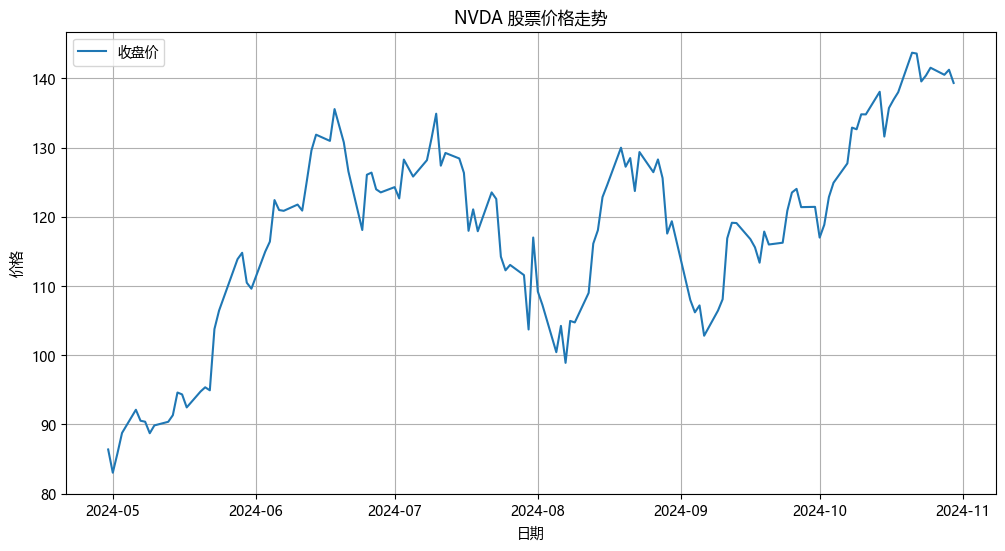

函数调用的输出:
当前价格: 139.17999267578125, 最高价格: 140.3300018310547, 最低价格: 136.80999755859375
请读取分析它的数据，作为一个专业的金融人员给出具体的见解和指导，要更深入的分析：[{'Date': Timestamp('2024-04-30 00:00:00-0400', tz='America/New_York'), 'Open': 87.22536912491692, 'High': 88.80410673208725, 'Low': 86.28553193485574, 'Close': 86.38751220703125, 'Volume': 363709000, 'Dividends': 0.0, 'Stock Splits': 0.0}, {'Date': Timestamp('2024-05-01 00:00:00-0400', tz='America/New_York'), 'Open': 85.0627384534076, 'High': 85.9855802137932, 'Low': 81.24137307099205, 'Close': 83.0270767211914, 'Volume': 559863000, 'Dividends': 0.0, 'Stock Splits': 0.0}, {'Date': Timestamp('2024-05-02 00:00:00-0400', tz='America/New_York'), 'Open': 84.43483783429492, 'High': 86.22254005204321, 'Low': 83.18604670637745, 'Close': 85.8026123046875, 'Volume': 377898000, 'Dividends': 0.0, 'Stock Splits': 0.0}, {'Date': Timestamp('2024-05-03 00:00:00-0400', tz='America/New_York'), 'Open': 87.77428416017375, 'High': 89.26603080091456, 'Low': 87.02540917635072, 'Close'

In [13]:
# 定义对话消息
messages = [
    {"role": "system", "content": "作为专业的股票交易员，整体走势，价格变动特点，技术面观察，关注的具体的点，交易用的是你的钱，你要分析并发号指令"},
    {"role": "user", "content": "我想知道英伟达的现在股票价格，以及它半年的历史走势与分析"}
]

# 定义可用的工具（函数）映射
available_tools = {
    "get_realtime_stock_data": get_realtime_stock_data,
    "historical_stock_data": historical_stock_data
}

# 运行对话
assistant_response = run_conversation(messages, tools, available_tools)

# 打印助手的响应
print(assistant_response.choices[0].message.content)

## 4. 最佳实践

1. 函数定义规范
- 使用清晰的函数名称
- 提供详细的描述
- 准确定义参数类型和要求

2. 错误处理

In [ ]:
try:
    function_result = execute_function(function_name, function_args)
except Exception as e:
    error_message = {"error": str(e)}
    # 将错误信息返回给模型处理

3. 函数调用控制
- `function_call="auto"`: 允许模型自主决定
- `function_call="none"`: 禁用函数调用
- `function_call={"name": "function_name"}`: 强制调用指定函数

4. 多轮对话管理
- 保持对话历史
- 合理处理上下文信息

5. 性能优化
- 缓存常用数据
- 批量处理请求
- 异步调用处理


In [40]:
openai.__version__

'1.51.2'